# **Projeto Volvo**

##Estimativa de valores de horímetro das máquinas da frota circulante

[Drive Volvo](https://drive.google.com/drive/folders/1HS80lS_XzGH7Tz9juk08d2IR65zZ4Cyv)

[Nosso Drive](https://drive.google.com/drive/folders/1QSw-csAJ1tW1FgAQQOY3tkXMBFcb2hmR?usp=sharing)


#0 - Informações sobre o projeto

###Projeto Volvo Construction Equipments na América Latina

####**Problema**
Dificuldade de obter dados da frota circulante, o que atrapalha a gestão e impacta o cliente

####**Perguntas**

1.   Como poderíamos inferir a partir de uma amostra da população de máquinas o valor de horímetro de um equipamento que não está comunicando através do dispositivo de telemetria?
2.   Seria possível estimar padrões de operação diária de um equipamento que não nos envia dados?


####**Solução**

Com base no histórico de dados, verificar se é possível prever padrões de operação diária de um equipamento (horímetro) que envia/não envia dados.


####**Objetivo**

Melhorar a gestão da frota circulante para que se alcance:

* o aumento da eficiência operacional da rede de distribuição
* a antecipação de necessidades dos clientes
* o aumento da produtividade das máquinas (uptime)
* a identificação de novas oportunidades em vendas de peças e serviços que não são exploradas
* o aumento de satisfação dos clientes Volvo CE

#1 - Hipóteses
*a serem testadas após o desenvolvimento do modelo preditivo*

* H0: É possível prever o horímetro da máquina com base no histórico de registros com precisão significativamente maior que a fornecida pelo cálculo atual (baseado em médias)
* H1: É possivel utilizar a mesma técnica para os 3 cenários de medição do problema?
1.   máquinas que enviaram dados nos últimos 4 dias
2.   máquinas que enviaram dados mas não recententemente
3.   máquinas que nunca enviaram dados
* H2: A técnica proposta garante resultados independentemente da classe da máquina: AHL; WL; EXC?
* H3: A técnica proposta garante resultados independentemente do segmento de aplicação da máquina?
* H4: A técnica proposta garante resultados independentemente do país onde a máquina está localizada?
* H5: A técnica proposta garante resultados independentemente do Dealer que realizou a venda?
* H6: A técnica proposta garante resultados independentemente da idade da máquina?

#2 - Dicionário

###**Variáveis**

**Dataset de equipamentos**

* Região: regiões de vendas. São 3 ('Hispânico Sul', 'Brasil', 'Hispânico Norte')

* País: onde a máquina foi comprada. São 3 ('Argentina', 'Brasil', 'México')

* Dealer: revendedor de peças. São 7 ('EPSA', 'Dinâmica', 'Gotemburgo', 'Linck', 'Tecnoeste', 'Tracbel', 'Ascendum')

* Segmento: atuação da máquina. São 5 ('Mining', 'Construction', 'Forestry', 'Agriculture', 'Industry')

* Modelo: linha da máquina WLO (Wheel Loader ou máquinas com pás articuladas), EXC (escavadeiras) e ART (caminhões articulados) ('ART', 'EXC', 'WLO')

* Chassis ID

* PIN17: identificação mais detalhada da máquina (não relevante para a análise)

* Delivery Date: data em que a máquina começou a trabalhar

* Obs.: observações internas da Volvo sobre a coleta de dados (não relevante para a análise)

* Estado: estado onde a máquina está operando atualmente ('San Luis', 'San Juan', 'Entre Ríos', 0, 'Jujuy','Provincia de Buenos Aires', 'Misiónes', 'Catamarca Province','Minas Gerais', 'Pará', 'Mato Grosso', 'Rondônia', 'Pernambuco','Bahia', 'Sergipe', 'Rio Grande do Norte', 'Paraná','Rio Grande do Sul', 'Santa Catarina', 'São Paulo','Mato Grosso do Sul', 'Rio de Janeiro', 'Veracruz','Estado de México', 'Nuevo León', 'Querétaro', 'Hidalgo','Coahuila de Zaragoza', 'Tabasco')

* Região: país onde a máquina está operando atualmente (pode diferir da de venda)

**Dataset de séries temporais**

* Chassis ID

* Machine History Date Day: dia no histórico de datas da máquina (dia de registro das horas)

* Compensated Working Hours By Day: quantidade de horas trabalhadas no dia

###**Outros**

Volvo CE: Volvo Construction Equipment

Horímetro: Quantidade de horas de operação que um equipamento tem

POC: proof of concept, a demonstration of a product in which work is focused on determining whether an idea can be turned into a reality

#3 - Importando bibliotecas

In [ ]:
!pip install pyjanitor==0.23.1 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.7/147.7 kB 3.1 MB/s eta 0:00:00


In [ ]:
import pandas_flavor as pf
import janitor

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from google.colab import drive
import matplotlib.pyplot as plt
from ipywidgets import interact
import statsmodels.api as sm

# bibliotecas para os modelos
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

# bibliotecas de métricas
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#4 - Importando Dados

In [ ]:
# importando o conjunto de dados
pd.set_option('display.max_columns', None)
drive.mount('/content/drive')

equip = pd.read_excel('/content/drive/MyDrive/Volvo/23w06_Equipamentos.xlsx')
temporal = pd.read_excel('/content/drive/MyDrive/Volvo/23w06_SeriesTemporais_Horimetros.xlsx',header = 3)
temporal.drop('Unnamed: 0', axis = 1,inplace = True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# importando o conjunto de dados
pd.set_option('display.max_columns', None)
drive.mount('/content/drive')
equip = pd.read_excel('/content/drive/MyDrive/Volvo/23w06_Equipamentos.xlsx')
temporal = pd.read_excel('/content/drive/MyDrive/Volvo/23w06_SeriesTemporais_Horimetros.xlsx')


#temporal.drop('Unnamed: 0', axis = 1,inplace = True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# importando o conjunto de dados
#equip = pd.read_excel('/content/23w06_Equipamentos.xlsx')
#temporal = pd.read_excel('/content/23w06_SeriesTemporais_Horimetros.xlsx')

#5 - Analisando dados

In [ ]:
# observando dataset equip
equip.head(2)

,Região,País,Dealer,Segmento,Modelo,Chassis ID,PIN17,Delivery Date,Obs.:,Estado,Região2
0,Hispânico Sul,Argentina,EPSA,Mining,ART,A040F320538,VCEA040FCG0320538,2020-11-26,NaN,San Luis,Argentina
1,Hispânico Sul,Argentina,EPSA,Construction,ART,A30G732052,VCE0A30GCL0732052,2020-06-22,NaN,San Juan,Argentina


In [ ]:
# observando informações básicas de equip
equip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Região         63 non-null     object        
 1   País           63 non-null     object        
 2   Dealer         63 non-null     object        
 3   Segmento       63 non-null     object        
 4   Modelo         63 non-null     object        
 5   Chassis ID     63 non-null     object        
 6   PIN17          57 non-null     object        
 7   Delivery Date  62 non-null     datetime64[ns]
 8   Obs.:          15 non-null     object        
 9   Estado         63 non-null     object        
 10  Região2        63 non-null     object        
dtypes: datetime64[ns](1), object(10)
memory usage: 5.5+ KB


In [ ]:
# verificando quantos valores nulos equip tem
equip.isna().sum()

Região            0
País              0
Dealer            0
Segmento          0
Modelo            0
Chassis ID        0
PIN17             6
Delivery Date     1
Obs.:            48
Estado            0
Região2           0
dtype: int64

In [ ]:
# identificando o índice do valor nulo de `Delivery Date`
indices_nulos = equip[equip['Delivery Date'].isnull()].index
print(indices_nulos)

Int64Index([22], dtype='int64')


In [ ]:
# verificando qual ID está sem delivery date
print(equip.loc[22, 'Chassis ID'])

EC220240109


In [ ]:
# removendo variáveis não relevantes e renomeando variáveis
equip = equip.drop(columns = ['Obs.:', 'PIN17'])
equip = equip.rename(columns={'Região.1': 'pais_operacao', 'País': 'pais_compra', 'Chassis ID': 'ID'})

In [ ]:
# observando dataset temporal
temporal.head(2)

,Unnamed: 0,Chassis Id*,Machine History Date Day,Compensated Working Hours By Day
0,NaN,A45G332092,2022-06-26,85.45
1,NaN,A30F072792,2022-08-10,82.30


In [ ]:
# observando informações básicas de temporal
temporal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118161 entries, 0 to 118160
Data columns (total 4 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   Unnamed: 0                        0 non-null       float64       
 1   Chassis Id*                       118161 non-null  object        
 2   Machine History Date Day          118161 non-null  datetime64[ns]
 3   Compensated Working Hours By Day  118161 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 3.6+ MB


In [ ]:
# verificando quantos valores nulos temporal tem
temporal.isna().sum()

Unnamed: 0                          118161
Chassis Id*                              0
Machine History Date Day                 0
Compensated Working Hours By Day         0
dtype: int64

In [ ]:
# verificando quantos IDs temporal tem
len(temporal['Chassis Id*'].unique())

62

In [ ]:
# verificando se o ID EC220240109 consta no dataset temporal
busca = temporal.loc[temporal['Chassis Id*'] == 'EC220240109'].index[0]
busca

12

In [ ]:
# verificando qual ID o equip tem a mais que temporal
chassis_temp = temporal['Chassis Id*'].unique()
chassis_equip = equip['ID'].unique()
valor_adicional = set(chassis_equip) - set(chassis_temp)

print(valor_adicional)

{'A30F720054'}


In [ ]:
# renomeando variável
temporal = temporal.rename(columns={'Compensated Working Hours By Day': 'Horas', 'Machine History Date Day': 'Dia', 'Chassis Id*': 'ID'})

In [ ]:
# removendo ID A30F720054
equip = equip.drop(equip[equip['ID'] == 'A30F720054'].index)

In [ ]:
# observando os valores dos IDs no temporal
chassis_valores = temporal.groupby('ID').describe()
chassis_valores

Unnamed: 0                                Horas             \
                 count mean std min 25% 50% 75% max   count       mean   
ID                                                                       
A030F720057        0.0  NaN NaN NaN NaN NaN NaN NaN  1805.0   6.851108   
A040F320538        0.0  NaN NaN NaN NaN NaN NaN NaN  2241.0   2.885249   
A040F320657        0.0  NaN NaN NaN NaN NaN NaN NaN  2121.0  14.792456   
A040F320672        0.0  NaN NaN NaN NaN NaN NaN NaN  2121.0   4.596603   
A30F072791         0.0  NaN NaN NaN NaN NaN NaN NaN  3041.0  11.465549   
...                ...  ...  ..  ..  ..  ..  ..  ..     ...        ...   
L60F073972         0.0  NaN NaN NaN NaN NaN NaN NaN   921.0  14.318868   
L60F074089         0.0  NaN NaN NaN NaN NaN NaN NaN   916.0   4.702040   
L60F074104         0.0  NaN NaN NaN NaN NaN NaN NaN   897.0   4.625585   
L60F074121         0.0  NaN NaN NaN NaN NaN NaN NaN   891.0   3.062028   
L60F074213         0.0  NaN NaN NaN NaN NaN NaN NaN   808.0   6.495359   

                                                                  
                  std  min        25%        50%      75%    max  
ID                                                                
A030F720057  7.257318  0.0   0.000446   5.600000  12.4000  57.20  
A040F320538  5.186442  0.0   0.001818   0.004074   4.3000  22.10  
A040F320657  7.534622  0.0  10.700000  18.000000  20.4000  29.40  
A040F320672  5.129515  0.0   0.025926   3.750000   7.2500  23.85  
A30F072791   5.937882  0.0   8.950000  12.500000  16.4000  35.35  
...               ...  ...        ...        ...      ...    ...  
L60F073972   6.292234  0.0  11.550000  15.450000  18.5500  32.50  
L60F074089   4.962446  0.0   0.091071   3.000000   8.7000  28.55  
L60F074104   3.941112  0.0   0.000000   4.900000   7.4500  21.35  
L60F074121   2.995701  0.0   1.400000   2.700000   4.2500  56.35  
L60F074213   5.074819  0.0   1.187500   6.325000   9.5625  26.50  

[62 rows x 16 columns]

In [ ]:
# juntando os dois datasets para visualizar
df_original = equip.merge(temporal, how = 'left', left_on = 'ID', right_on = 'ID')

In [ ]:
df = df_original.copy()

In [ ]:
# criando gráficos
@interact(id = temporal.ID.unique().tolist())
def graficos(id):
    plt.figure(figsize= (16,3))
    ax = sns.lineplot(data = temporal[temporal.ID == id],
                      x = 'Dia',
                      y = 'Horas')
    plt.show()

interactive(children=(Dropdown(description='id', options=('A45G332092', 'A30F072792', 'A30G732035', 'A30G73202…

In [ ]:
# criando variável para armazenar as variáveis que vão ser apresentadas na tabela geral
cols = ['Região', 'País Compra','Dealer','Segmento','Modelo','Estado','País Operação', 'ID']

In [ ]:
# criando tabela geral para visualizar os principais dados das principais variáveis
@interact(agg_fun = ['sum', 'mean','max'], col_groupby = cols)


def tabela_geral(agg_fun,col_groupby):
    df2 = df.groupby([col_groupby], sort = 'Horas')[['Horas']].agg(agg_fun)\
              .sort_values('Horas', ascending = False)

    return df2.style.highlight_min(color = 'black')\
                    .highlight_max(color = 'lightcoral')

interactive(children=(Dropdown(description='agg_fun', options=('sum', 'mean', 'max'), value='sum'), Dropdown(d…

#6 - Criando novas variáveis


### 6.1 - Método 1: Aplicando One Hot Encoding nas variáveis categóricas

In [ ]:
#criando df2 para o Método 2
df2 = df

In [ ]:
# aplicando One Hot Encoding às variáveis
df_aux = pd.get_dummies(df['Segmento'], prefix='Segmento')
df = pd.concat([df, df_aux], axis=1)
df_aux = pd.get_dummies(df['Modelo'], prefix='Modelo')
df = pd.concat([df, df_aux], axis=1)
df_aux = pd.get_dummies(df['Dealer'], prefix='Dealer')
df = pd.concat([df, df_aux], axis=1)
df_aux = pd.get_dummies(df['Região'], prefix='Região')
df = pd.concat([df, df_aux], axis=1)

In [ ]:
# deletando variáveis originais
df.drop(['Segmento', 'Modelo', 'Dealer', 'Região'], axis=1, inplace=True)

In [ ]:
# apagando os dados vazios
df = df.dropna()

In [ ]:
df.head(2)

,pais_compra,ID,Delivery Date,Estado,Região2,Unnamed: 0,Dia,Horas,Segmento_Agriculture,Segmento_Construction,Segmento_Forestry,Segmento_Industry,Segmento_Mining,Modelo_ART,Modelo_EXC,Modelo_WLO,Dealer_Ascendum,Dealer_Dinâmica,Dealer_EPSA,Dealer_Gotemburgo,Dealer_Linck,Dealer_Tecnoeste,Dealer_Tracbel,Região_Brasil,Região_Hispânico Norte,Região_Hispânico Sul


### 6.2 - Método 2: Adicionando médias dos horimetros

In [ ]:
dayOfWeek={0:'Seg', 1:'Ter', 2:'Qua', 3:'Qui', 4:'Sex', 5:'Sab', 6:'Dom'}
df2['dia_da_semana'] = df2.Dia.dt.dayofweek.map(dayOfWeek)
df2["mes"] = df2.Dia.dt.month

In [ ]:
df2.groupby(['Modelo',"pais_operacao","dia_da_semana"])[["Horas"]].mean().reset_index()

KeyError: ignored

In [ ]:
df2.groupby(['ID',"dia_da_semana"])[["Horas"]].mean().reset_index()

,ID,dia_da_semana,Horas
0,A030F720057,Dom,1.400040
1,A030F720057,Qua,9.219244
2,A030F720057,Qui,9.591219
3,A030F720057,Sab,4.725538
4,A030F720057,Seg,6.170583
...,...,...,...
429,L60F074213,Qui,8.481739
430,L60F074213,Sab,5.934783
431,L60F074213,Seg,5.556897
432,L60F074213,Sex,8.137391


In [ ]:
# Seleciona as colunas para o loop for
cols = ["Região","Dealer","Segmento","Modelo"]

# Coluna que será feito o calculo
agg = ["Horas"]

# Métricas
func = ['mean',"min","max",'median']

In [ ]:
for col in cols:
  for fun in func:
    df2 = df2.groupby_agg(by = [col,"dia_da_semana","ID",],
                        agg = fun,
                        agg_column_name = ["Horas"],
                        new_column_name = f'{col}_{fun}_Horas')

In [ ]:
for col in cols:
  for fun in func:
    df2 = df2.groupby_agg(by = ["ID", col, "dia_da_semana"],
                        agg = fun,
                        agg_column_name = ["Horas"],
                        new_column_name = f'{col}_{fun}_Horas')

<ipython-input-39-96af6dd494f4>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df2.corr(), annot=True);


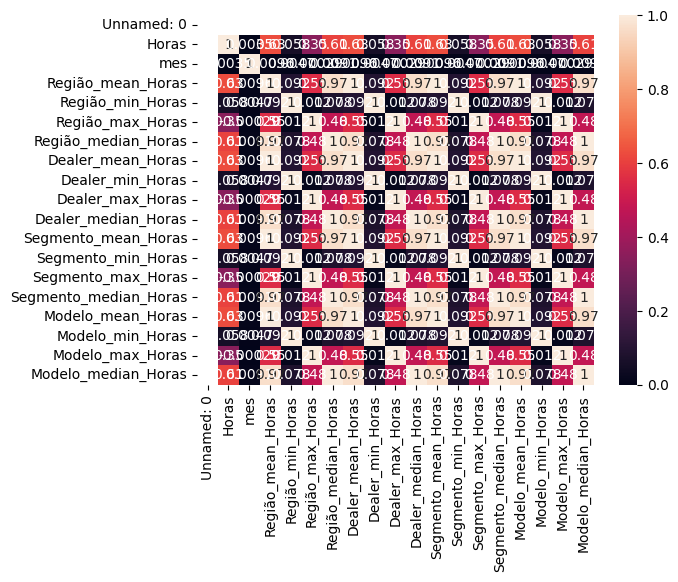

In [ ]:
# verificando as correções, porém com o gráfica fica pouca visualização
sns.heatmap(df2.corr(), annot=True);

In [ ]:
# apagando os dados vazios
df2 = df2.dropna()

In [ ]:
df2.head(2)

,Região,pais_compra,Dealer,Segmento,Modelo,ID,Delivery Date,Estado,Região2,Unnamed: 0,Dia,Horas,dia_da_semana,mes,Região_mean_Horas,Região_min_Horas,Região_max_Horas,Região_median_Horas,Dealer_mean_Horas,Dealer_min_Horas,Dealer_max_Horas,Dealer_median_Horas,Segmento_mean_Horas,Segmento_min_Horas,Segmento_max_Horas,Segmento_median_Horas,Modelo_mean_Horas,Modelo_min_Horas,Modelo_max_Horas,Modelo_median_Horas


#**7 - Ajustando e Separando Dados (Treino e Teste)**

### 7.1 - Método 1

In [ ]:
# apagando as variaveis categoricas e ficando apenas as numericas PARA O MODELO 1
df.drop(['pais_compra','ID','Delivery Date','Estado','pais_operacao','Dia'], axis=1, inplace=True)

KeyError: ignored

In [ ]:
# criando X e y
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

### 7.2 - Método 2

In [ ]:
# apagando as variaveis categoricas e ficando apenas as numericas
df2.drop(['Região','Dealer','Segmento','Modelo','pais_compra','ID','Delivery Date','Estado','pais_operacao','Dia',"dia_da_semana","mes"], axis=1, inplace=True)

In [ ]:
# criando X e y
X = df2.iloc[:, 1:]
y = df2.iloc[:, 0]

### 7.3 Treinando os modelos

In [ ]:
# separando dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

#**8 - Aplicando Modelos**


### 8.1 - Regressão Linear

In [ ]:
# criando modelo de Regressão Linear
modeloLR = LinearRegression()
# fazendo o fit/ajustando o modelo com os dados de treinamento
modeloLR.fit(X_train, y_train)

LinearRegression()

### 8.2 - Random Forest

In [ ]:
# criando modelo Random Forest
modeloRF = RandomForestRegressor(n_estimators=100, min_samples_leaf=2)
# fazendo o fit/ajustando o modelo com os dados de treinamento
modeloRF.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=2)

### 8.3 - Random Forest (alterando parâmetros)

In [ ]:
# tunando modelo Random Forest
modeloRF2 = RandomForestRegressor(n_estimators=200, min_samples_leaf=2)
# fazendo o fit/ajustando o modelo com os dados de treinamento
modeloRF2.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=2, n_estimators=200)

### 8.4 - Regressão Lasso

In [ ]:
# criando modelo de Lasso
modeloRL = Lasso()

# fazendo o fit/ajustando o modelo com os dados de treinamento
modeloRL.fit(X_train, y_train)

Lasso()

### 8.5 - Regressão de cume (Ridge)

In [ ]:
# criando modelo de Cume
modeloRC = Ridge()

# fazendo o fit/ajustando o modelo com os dados de treinamento
modeloRC.fit(X_train, y_train)

Ridge()

### 8.6 - Regressão de cume (Ridge)2

In [ ]:
# criando modelo de Cume
modeloRC2 = Ridge(alpha=0)

# fazendo o fit/ajustando o modelo com os dados de treinamento
modeloRC2.fit(X_train, y_train)

Ridge(alpha=0)

### 8.6 - Regressão XGBoost

In [ ]:
# criando modelo de Regressão XGBoost
modeloXGB = XGBRegressor()
# fazendo o fit/ajustando o modelo com os dados de treinamento
modeloXGB.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

### 8.7 - Regressão XGBoost2 (alterando parâmetros)

In [ ]:
# tunando modelo de Regressão XGBoost
modeloXGB2 = XGBRegressor(n_estimators=2000, max_depth=8)
# fazendo o fit/ajustando o modelo com os dados de treinamento
modeloXGB2.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=2000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

### 8.8 - Decision Tree Regressor

In [ ]:
# criando modelo
modeloDT = DecisionTreeRegressor()
# fazendo o fit/ajustando o modelo com os dados de treinamento
modeloDT.fit(X_train, y_train)

DecisionTreeRegressor()

### 8.9 - KNN Regressor

In [ ]:
# criando modelo KNN Regressor
modeloKNN = KNeighborsRegressor(n_neighbors=5) # considerando 5 neighbors
# fazendo o fit/ajustando o modelo com os dados de treinamento
modeloKNN.fit(X_train, y_train)

KNeighborsRegressor()

### 8.10 - KNN Regressor (alterando parâmetros)

In [ ]:
# criando modelo KNN Regressor
modeloKNN2 = KNeighborsRegressor(n_neighbors=6) # considerando 6 neighbors
# fazendo o fit/ajustando o modelo com os dados de treinamento
modeloKNN2.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=6)

#**9 - Comparando Modelos**


### 9.1 - Método 1

In [ ]:
# Função para calcular o MAE - Método 1
def calcular_mae(modelo):
    predicoes = modelo.predict(X_test)
    erro_absoluto = mean_absolute_error(predicoes, y_test)
    return erro_absoluto

# Calcular e imprimir o MAE para cada modelo
Erro_absoluto_LR_modelo1 = calcular_mae(modeloLR)
print('Regressão Linear:', Erro_absoluto_LR_modelo1)
Erro_absoluto_RF_modelo1 = calcular_mae(modeloRF)
print('Random Forest:', Erro_absoluto_RF_modelo1)
Erro_absoluto_RF2_modelo1 = calcular_mae(modeloRF2)
print('Random Forest2:', Erro_absoluto_RF2_modelo1)
Erro_absoluto_RL_modelo1 = calcular_mae(modeloRL)
print('Regressão de Laço:', Erro_absoluto_RL_modelo1)
Erro_absoluto_RC_modelo1 = calcular_mae(modeloRC)
print('Regressão de Cume:', Erro_absoluto_RC_modelo1)
Erro_absoluto_RC2_modelo1 = calcular_mae(modeloRC)
print('Regressão de Cume2:', Erro_absoluto_RC2_modelo1)
Erro_absoluto_XGB_modelo1 = calcular_mae(modeloXGB)
print('XGBoost:', Erro_absoluto_XGB_modelo1)
Erro_absoluto_XGB2_modelo1 = calcular_mae(modeloXGB2)
print('XGBoost2:', Erro_absoluto_XGB2_modelo1)
Erro_absoluto_DT_modelo1 = calcular_mae(modeloDT)
print('Decision Tree:', Erro_absoluto_DT_modelo1)
Erro_absoluto_KNN_modelo1 = calcular_mae(modeloKNN)
print('KNN:', Erro_absoluto_KNN_modelo1)
Erro_absoluto_KNN2_modelo1 = calcular_mae(modeloKNN2)
print('KNN2:', Erro_absoluto_KNN2_modelo1)

Regressão Linear: 4.87600812854132
Random Forest: 4.066473539320921
Random Forest2: 4.066388298460103
Regressão de Laço: 5.151700006383883
Regressão de Cume: 4.8786578323443255
Regressão de Cume2: 4.8786578323443255
XGBoost: 4.066162574717939
XGBoost2: 4.06615916315283
Decision Tree: 4.066156375686457
KNN: 4.593604934830322
KNN2: 4.49084985108633


In [ ]:
# Função para calcular e imprimir MSE e RMSE - Método 1
def calcular_e_imprimir_mse_rmse(modelo, nome_modelo):
    predicoes = modelo.predict(X_test)
    mse = mean_squared_error(predicoes, y_test)
    rmse = np.sqrt(mse)
    print(f'\nMSE do {nome_modelo}: {mse}')
    print(f'RMSE do {nome_modelo}: {rmse}')

# Calcular e imprimir MSE e RMSE para cada modelo
calcular_e_imprimir_mse_rmse(modeloLR, 'Regressão Linear')
calcular_e_imprimir_mse_rmse(modeloRF, 'Random Forest')
calcular_e_imprimir_mse_rmse(modeloRF2, 'Random Forest2')
calcular_e_imprimir_mse_rmse(modeloRL, 'Regressão de Lasso')
calcular_e_imprimir_mse_rmse(modeloRC, 'Regressão de Cume')
calcular_e_imprimir_mse_rmse(modeloRC2, 'Regressão de Cume2')
calcular_e_imprimir_mse_rmse(modeloXGB, 'XGBoost')
calcular_e_imprimir_mse_rmse(modeloXGB2, 'XGBoost2')
calcular_e_imprimir_mse_rmse(modeloDT, 'Decision Tree')
calcular_e_imprimir_mse_rmse(modeloKNN, 'KNN')
calcular_e_imprimir_mse_rmse(modeloKNN2, 'KNN2')


MSE do Regressão Linear: 37.17268627221142
RMSE do Regressão Linear: 6.096940730580495

MSE do Random Forest: 28.800950417909963
RMSE do Random Forest: 5.366651695229527

MSE do Random Forest2: 28.800408793348293
RMSE do Random Forest2: 5.366601232935823

MSE do Regressão de Lasso: 41.48274968943937
RMSE do Regressão de Lasso: 6.440710340439118

MSE do Regressão de Cume: 37.17154817473011
RMSE do Regressão de Cume: 6.096847396378731

MSE do Regressão de Cume2: 43.5957404268057
RMSE do Regressão de Cume2: 6.6027070529295555

MSE do XGBoost: 28.800223469442546
RMSE do XGBoost: 5.366583966495125

MSE do XGBoost2: 28.800230400064162
RMSE do XGBoost2: 5.366584612215125

MSE do Decision Tree: 28.800230869640107
RMSE do Decision Tree: 5.366584655965105

MSE do KNN: 38.12706844514456
RMSE do KNN: 6.174712013134261

MSE do KNN2: 36.487941993551075
RMSE do KNN2: 6.040524976651539


In [ ]:
# Função para calcular e imprimir R²
def calcular_e_imprimir_r2(modelo, nome_modelo):
    predicoes = modelo.predict(X_test)
    r2 = r2_score(predicoes, y_test)
    print(f'R² do {nome_modelo}: {r2}')

# Calcular e imprimir R² para cada modelo
calcular_e_imprimir_r2(modeloLR, 'Regressão Linear')
calcular_e_imprimir_r2(modeloRF, 'Random Forest')
calcular_e_imprimir_r2(modeloRF2, 'Random Forest2')
calcular_e_imprimir_r2(modeloRL, 'Regressão de Lasso')
calcular_e_imprimir_r2(modeloRC, 'Regressão de Cume')
calcular_e_imprimir_r2(modeloRC2, 'Regressão de Cume2')
calcular_e_imprimir_r2(modeloXGB, 'XGBoost')
calcular_e_imprimir_r2(modeloXGB2, 'XGBoost2')
calcular_e_imprimir_r2(modeloDT, 'Decision Tree')
calcular_e_imprimir_r2(modeloKNN, 'KNN')
calcular_e_imprimir_r2(modeloKNN2, 'KNN2')

R² do Regressão Linear: -7.364406138513049
R² do Random Forest: -1.2883241173744135
R² do Random Forest2: -1.293483232098485
R² do Regressão de Lasso: -1.3146408135733805e+31
R² do Regressão de Cume: -7.308517168190825
R² do Regressão de Cume2: -2.5013641916803317
R² do XGBoost: -1.2888484365877027
R² do XGBoost2: -1.2888158967532402
R² do Decision Tree: -1.28879424870235
R² do KNN: -1.106878588381634
R² do KNN2: -0.9204927293942262


In [ ]:
resultados_1 = pd.DataFrame([Erro_absoluto_LR_modelo1,
                           Erro_absoluto_RF_modelo1,
                           Erro_absoluto_RF2_modelo1,
                           Erro_absoluto_RL_modelo1,
                           Erro_absoluto_RC_modelo1,
                           Erro_absoluto_RC2_modelo1,
                           Erro_absoluto_XGB_modelo1,
                           Erro_absoluto_XGB2_modelo1,
                           Erro_absoluto_DT_modelo1,
                           Erro_absoluto_KNN_modelo1,
                           Erro_absoluto_KNN2_modelo1])


resultados_1["modelos"] = ["Reg. Linear",
                         "R. Forest",
                         "R. Forest2",
                         "Reg. Lasso",
                         "Reg. Cume",
                         "Reg. Cume2",
                         "XGBoost",
                         "XGBoost2",
                         "Decision Tree",
                         "KNN",
                         "KNN2"]

resultados_1 = resultados_1.rename({0: "erro_medio"}, axis = 1)

In [ ]:
resultados_1["metodo"] = 1

In [ ]:
resultados_1 = resultados_1.rename({0: "erro_medio"}, axis = 1)

In [ ]:
resultados_1

,erro_medio,modelos,metodo
0,4.876008,Reg. Linear,1
1,4.066474,R. Forest,1
2,4.066388,R. Forest2,1
3,5.151700,Reg. Lasso,1
4,4.878658,Reg. Cume,1
5,4.878658,Reg. Cume2,1
6,4.066163,XGBoost,1
7,4.066159,XGBoost2,1
8,4.066156,Decision Tree,1
9,4.593605,KNN,1


### 9.2 - Método 2

In [ ]:
# Função para calcular o MAE - Método 2
def calcular_mae(modelo):
    predicoes = modelo.predict(X_test)
    erro_absoluto = mean_absolute_error(predicoes, y_test)
    return erro_absoluto

# Calcular e imprimir o MAE para cada modelo
Erro_absoluto_LR_modelo2 = calcular_mae(modeloLR)
print('Regressão Linear:', Erro_absoluto_LR_modelo2)
Erro_absoluto_RF_modelo2 = calcular_mae(modeloRF)
print('Random Forest:', Erro_absoluto_RF_modelo2)
Erro_absoluto_RF2_modelo2 = calcular_mae(modeloRF2)
print('Random Forest2:', Erro_absoluto_RF2_modelo2)
Erro_absoluto_RL_modelo2 = calcular_mae(modeloRL)
print('Regressão de Laço:', Erro_absoluto_RL_modelo2)
Erro_absoluto_RC_modelo2 = calcular_mae(modeloRC)
print('Regressão de Cume:', Erro_absoluto_RC_modelo2)
Erro_absoluto_RC2_modelo2 = calcular_mae(modeloRC2)
print('Regressão de Cume2:', Erro_absoluto_RC2_modelo2)
Erro_absoluto_XGB_modelo2 = calcular_mae(modeloXGB)
print('XGBoost:', Erro_absoluto_XGB_modelo2)
Erro_absoluto_XGB2_modelo2 = calcular_mae(modeloXGB2)
print('XGBoost2:', Erro_absoluto_XGB2_modelo2)
Erro_absoluto_DT_modelo2 = calcular_mae(modeloDT)
print('Decision Tree:', Erro_absoluto_DT_modelo2)
Erro_absoluto_KNN_modelo2 = calcular_mae(modeloKNN)
print('KNN:', Erro_absoluto_KNN_modelo2)
Erro_absoluto_KNN2_modelo2 = calcular_mae(modeloKNN2)
print('KNN2:', Erro_absoluto_KNN2_modelo2)

Regressão Linear: 3.56709482127068
Random Forest: 3.5817487005696735
Random Forest2: 3.582081350500338
Regressão de Laço: 3.622485589079435
Regressão de Cume: 3.5670948373084266
Regressão de Cume2: 3.5622873333067675
XGBoost: 3.581880059877019
XGBoost2: 3.5821860112324972
Decision Tree: 3.5821924527680244
KNN: 3.8664215199012446
KNN2: 3.795736260505864


In [ ]:
# Função para calcular e imprimir MSE e RMSE - Método 2
def calcular_e_imprimir_mse_rmse(modelo, nome_modelo):
    predicoes = modelo.predict(X_test)
    mse = mean_squared_error(predicoes, y_test)
    rmse = np.sqrt(mse)
    print(f'\nMSE do {nome_modelo}: {mse}')
    print(f'RMSE do {nome_modelo}: {rmse}')

# Calcular e imprimir MSE e RMSE para cada modelo
calcular_e_imprimir_mse_rmse(modeloLR, 'Regressão Linear')
calcular_e_imprimir_mse_rmse(modeloRF, 'Random Forest')
calcular_e_imprimir_mse_rmse(modeloRF2, 'Random Forest2')
calcular_e_imprimir_mse_rmse(modeloRL, 'Regressão de Lasso')
calcular_e_imprimir_mse_rmse(modeloRC, 'Regressão de Cume')
calcular_e_imprimir_mse_rmse(modeloRC2, 'Regressão de Cume2')
calcular_e_imprimir_mse_rmse(modeloXGB, 'XGBoost')
calcular_e_imprimir_mse_rmse(modeloXGB2, 'XGBoost2')
calcular_e_imprimir_mse_rmse(modeloDT, 'Decision Tree')
calcular_e_imprimir_mse_rmse(modeloKNN, 'KNN')
calcular_e_imprimir_mse_rmse(modeloKNN2, 'KNN2')


MSE do Regressão Linear: 25.185476259227435
RMSE do Regressão Linear: 5.018513351504351

MSE do Random Forest: 25.42358123067243
RMSE do Random Forest: 5.042180206088674

MSE do Random Forest2: 25.42137611789364
RMSE do Random Forest2: 5.04196153474951

MSE do Regressão de Lasso: 25.29347152004985
RMSE do Regressão de Lasso: 5.0292615283011335

MSE do Regressão de Cume: 25.185476371472195
RMSE do Regressão de Cume: 5.01851336268742

MSE do Regressão de Cume2: 26.082841065490598
RMSE do Regressão de Cume2: 5.107136288125724

MSE do XGBoost: 25.419661016293027
RMSE do XGBoost: 5.0417914491074525

MSE do XGBoost2: 25.423180011777994
RMSE do XGBoost2: 5.042140419680713

MSE do Decision Tree: 25.42325388035038
RMSE do Decision Tree: 5.0421477447958996

MSE do KNN: 30.666202867701926
RMSE do KNN: 5.537707365661527

MSE do KNN2: 29.522315575098503
RMSE do KNN2: 5.433444172447022


In [ ]:
# Função para calcular e imprimir R²
def calcular_e_imprimir_r2(modelo, nome_modelo):
    predicoes = modelo.predict(X_test)
    r2 = r2_score(predicoes, y_test)
    print(f'R² do {nome_modelo}: {r2}')

# Calcular e imprimir R² para cada modelo
calcular_e_imprimir_r2(modeloLR, 'Regressão Linear')
calcular_e_imprimir_r2(modeloRF, 'Random Forest')
calcular_e_imprimir_r2(modeloRF2, 'Random Forest2')
calcular_e_imprimir_r2(modeloRL, 'Regressão de Lasso')
calcular_e_imprimir_r2(modeloRC, 'Regressão de Cume')
calcular_e_imprimir_r2(modeloXGB, 'XGBoost')
calcular_e_imprimir_r2(modeloXGB2, 'XGBoost2')
calcular_e_imprimir_r2(modeloDT, 'Decision Tree')
calcular_e_imprimir_r2(modeloKNN, 'KNN')
calcular_e_imprimir_r2(modeloKNN2, 'KNN2')

R² do Regressão Linear: -0.5608472522885699
R² do Random Forest: -0.5723978596649337
R² do Random Forest2: -0.569767013875458
R² do Regressão de Lasso: -0.7777661842336328
R² do Regressão de Cume: -0.5608478730742761
R² do XGBoost: -0.5711237636079691
R² do XGBoost2: -0.5712337467099693
R² do Decision Tree: -0.5712353661779406
R² do KNN: -0.4036283635605913
R² do KNN2: -0.41058617316382584


In [ ]:
resultados_2 = pd.DataFrame([Erro_absoluto_LR_modelo2,
                           Erro_absoluto_RF_modelo2,
                           Erro_absoluto_RF2_modelo2,
                           Erro_absoluto_RL_modelo2,
                           Erro_absoluto_RC_modelo2,
                           Erro_absoluto_RC2_modelo2,
                           Erro_absoluto_XGB_modelo2,
                           Erro_absoluto_XGB2_modelo2,
                           Erro_absoluto_DT_modelo2,
                           Erro_absoluto_KNN_modelo2,
                           Erro_absoluto_KNN2_modelo2])

resultados_2["modelos"] = ["Reg. Linear",
                         "R. Forest",
                         "R. Forest2",
                         "Reg. Lasso",
                         "Reg. Cume",
                         "Reg. Cume2",
                         "XGBoost",
                         "XGBoost2",
                         "Decision Tree",
                         "KNN",
                         "KNN2"]

In [ ]:
resultados_2["metodo"] = 2

In [ ]:
resultados_2 = resultados_2.rename({0: "erro_medio"}, axis = 1)

In [ ]:
resultados_2

,erro_medio,modelos,metodo
0,3.567095,Reg. Linear,2
1,3.581749,R. Forest,2
2,3.582081,R. Forest2,2
3,3.622486,Reg. Lasso,2
4,3.567095,Reg. Cume,2
5,3.562287,Reg. Cume2,2
6,3.581880,XGBoost,2
7,3.582186,XGBoost2,2
8,3.582192,Decision Tree,2
9,3.866422,KNN,2


#10 - Comparando Métodos

In [ ]:
metricas = pd.concat([resultados_1,resultados_2])

In [ ]:
metricas

,erro_medio,modelos,metodo
0,4.876008,Reg. Linear,1
1,4.066474,R. Forest,1
2,4.066388,R. Forest2,1
3,5.151700,Reg. Lasso,1
4,4.878658,Reg. Cume,1
5,4.878658,Reg. Cume2,1
6,4.066163,XGBoost,1
7,4.066159,XGBoost2,1
8,4.066156,Decision Tree,1
9,4.593605,KNN,1


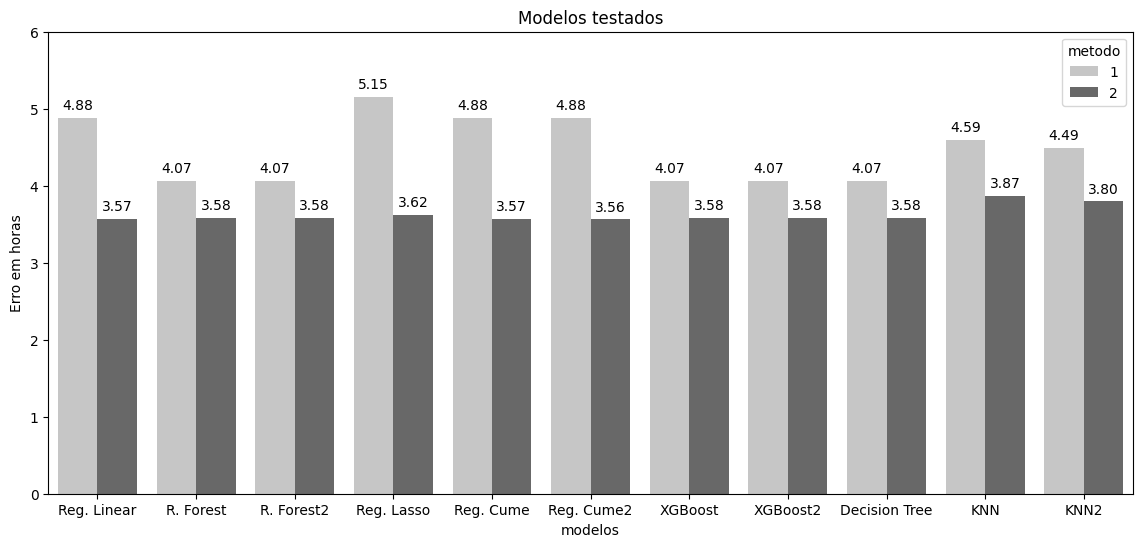

In [ ]:
plt.figure(figsize = (14,6))

splot = sns.barplot(data= metricas,
            x = "modelos",
            y = "erro_medio",
            hue = "metodo",
            palette = "Greys");
splot.set_ylim(0,6)
splot.set_ylabel("Erro em horas")

plt.title("Modelos testados")


for g in splot.patches:
    splot.annotate(format(g.get_height(), '.2f'),
                   (g.get_x() + g.get_width() / 2., g.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 9),
                   textcoords = 'offset points')

#**11 - Conclusão**


O melhor modelo para a previsão é a Regressão Linear.